In [92]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab
import random
from random import randint
import math 

## Algorithme génétique pour le probleme du voyageur de commerce

***Probleme :***

. Soit un graphe non orienté complet valué (tous les sommets sont connectés entre
eux avec des aretes à cout positif) contenant n sommets.
. Extraire un circuit Hamiltonien le plus court (passant par tous les sommets du
graphe une et une seule fois)


## ***Quelques indications :***

* .Individu = un circuit quelconque (passage par tous les sommets du graphe)

* . Fonction d'evaluation : La valeur d'adaptation doit etre croissante avec l'adaptation de la solution du probleme .

* . La valeur d'adaptation est inversement proportionnel à la distance du chemin de chaque individu (car on cherche le circuit Hamiltonien le plus court)



### References 

 * http://deptinfo.unice.fr/twiki/pub/Linfo/PlanningDesSoutenances20032004/Radet-Souquet.pdf

 * https://www.ripublication.com/ijcir17/ijcirv13n7_15.pdf
 
 * https://www.researchgate.net/publication/282733130_Analyse_des_performances_d'operateurs_de_mutation_genetique_a_la_resolution_du_Probleme_de_Voyageur_de_Commerce

In [93]:
nb_sommets=5
poids_max=12

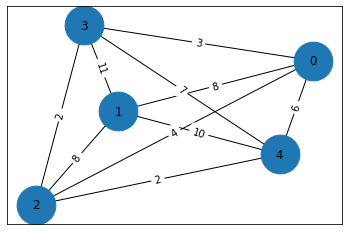

In [94]:
G=nx.Graph()

G.add_weighted_edges_from( (i,j,randint(1,poids_max)) for i in range(nb_sommets) for j in range(i+1,nb_sommets))

G.edges(data=True)

edge_labels=dict([((u,v,),d['weight'])for u,v,d in G.edges(data=True)])
pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw_networkx(G,pos, node_size=1500,edge_cmap=plt.cm.Reds)
pylab.show()  

In [95]:
"""
  Tous les somments sont connectés entre eux avec des aretes à coût positif
  donc on fait l'ensemble des chemin pour chaque sommet
  
"""
def ajouter_les_poids(genes,edge_labels):
    res=[]
    for ind in genes:
        new_ind={}
        for i in range(len(ind)-1):
            if (ind[i],ind[i+1]) not in list(edge_labels.keys()):
                if (ind[i+1],ind[i]) in list(edge_labels.keys()):
                    new_ind[(ind[i+1],ind[i])]=edge_labels[(ind[i+1],ind[i])]
            else:
                new_ind[(ind[i],ind[i+1])]=edge_labels[(ind[i],ind[i+1])]
                
        res.append(new_ind)
    return res
    
def create_population(G,edge_labels):
    genes = []
    for node in G.nodes():
        for n in G.nodes():
            for path in nx.all_simple_paths(G, source=node, target=n):
                if len(path)==len(G.nodes()):
                    genes.append(path)
    return ajouter_les_poids(genes,edge_labels)

In [96]:
# faire les test
population=create_population(G,edge_labels)
#population

### La section 

Nous utilisons ici la méthode de sélection par roulette. (*)

On calcule d'abord la valeur moyenne de la fonction d'évaluation dans la population :

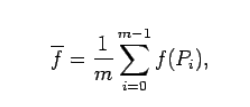


où ***Pi*** est l'individu i de la population et ***m*** la taille de la population.

La place d'un individu ***Pi*** dans la roulette est proportionnel à 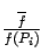. 

On sélectionne alors ***m/2*** individus pour la
reproduction.

Il y a aussi la possibilité d'avoir une politique d'«élitisme». C'est à dire qu'à chaque
étape de sélection le meilleur chromosome est automatiquement sélectionné.

(réf : https://www.researchgate.net/publication/282733130_Analyse_des_performances_d'operateurs_de_mutation_genetique_a_la_resolution_du_Probleme_de_Voyageur_de_Commerce)

###  (*) La loterie biaisée ou roulette wheel :

Cette méthode est la plus connue et la plus utilisée.

Avec cette méthode chaque individu a une chance d'être selectionné proportionnelle à sa
performance, donc plus les individus sont adaptés au problème, plus ils ont de chances d'être
séléctionnés.

Pour utiliser l'image de la "roue du forain", chaque individu se voit attribué un secteur dont
l'angle est proportionnel à son adaptation, sa "fitness".


On fait tourner la roue et quand elle cesse de tourner on séléctionne l'individu correspondant au
secteur désigné par une sorte de "curseur", curseur qui pointe sur un secteur particulier de celle-ci
après qu'elle se soit arrêté de tourner.

réf : (  http://deptinfo.unice.fr/twiki/pub/Linfo/PlanningDesSoutenances20032004/Radet-Souquet.pdf )

In [97]:
#population[0].values()

In [98]:
"""
   Cette fonction permet de calculer le table de distance de chaque individus (circuit)
"""
def table_distance(population):
    path_table = []
    for ind in population:
        path_table.append(sum(list(ind.values())))
    return path_table
#distance=table_distance(population)

In [99]:
"""
  Permet de selectionner l'individu avec la proba la plus haut à être selectioné pour
  la creation d'une nouvelle population plus le genes_path ( le circuit hamiltonien) est bas plus 
  il a la possibilité d'être parent 
"""
def generate_roulette(fitness_vec):
    total = np.sum(fitness_vec)
    roulette = np.zeros(len(fitness_vec))
    for i in range(len(fitness_vec)):
        roulette[i] = fitness_vec[i]/total
    return roulette


def roulette_choice(fitness_vec):
    roulette = generate_roulette(fitness_vec)
    choiced = np.random.choice(len(roulette), 2, replace=True, p=roulette)
    return choiced

In [100]:
#roulette_choice([1/i for i in distance])

###  La sélection par tournois :

Cette méthode est celle avec laquelle on obtient les résultats les plus satisfaisants.

Le principe de cette méthode est le suivant : on effectue un tirage avec remise de deux
individus de P, et on les fait "combattre". Celui qui a la fitness la plus élevée l'emporte avec
une probabilité p comprise entre 0.5 et 1. On répète ce processus n fois de manière a obtenir les
n individus de P' qui serviront de parents.

La variance de cette méthode est élevée et le fait d'augmenter ou de diminuer la valeur de p
permet respectivement de diminuer ou d'augementer la pression de la sélection.

In [101]:
def selection_par_tournois(population):
    
    parent1 = random.sample(population, k=2)[0]
    parent2 = random.sample(population, k=2)[1]
    print(" 1 ",parent1)
    print(" 2 ",parent2)
    if sum(list(parent1.values())) < sum(list(parent2.values())):
        return [index for index in range(len(population)) if population[index] == parent1] 
    else:
        return [index for index in range(len(population)) if population[index] == parent2] 

In [102]:
#selection_par_tournois(population)

### L'opérateur de croisement ou crossover

Le crossover utilisé par les algorithmes génétiques est la transposition informatique du mécanisme
qui permet, dans la nature, la production de chromosomes qui héritent partiellement des
caractéristiques des parents.

Son rôle fondamental est de permettre la recombinaison des informations présentes dans le
patrimoine génétique de la population.

On a fait deux types de crossover 

 -  Partially Mapped Crossover (PMX)
 -  Two Point Crossover

### Partially Mapped Crossover 

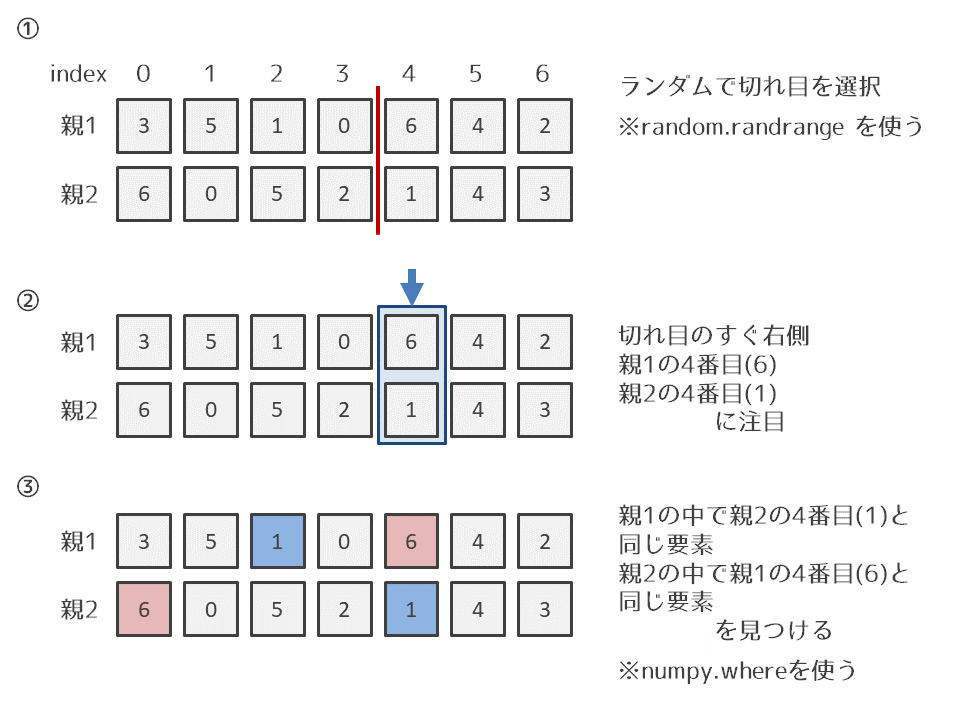
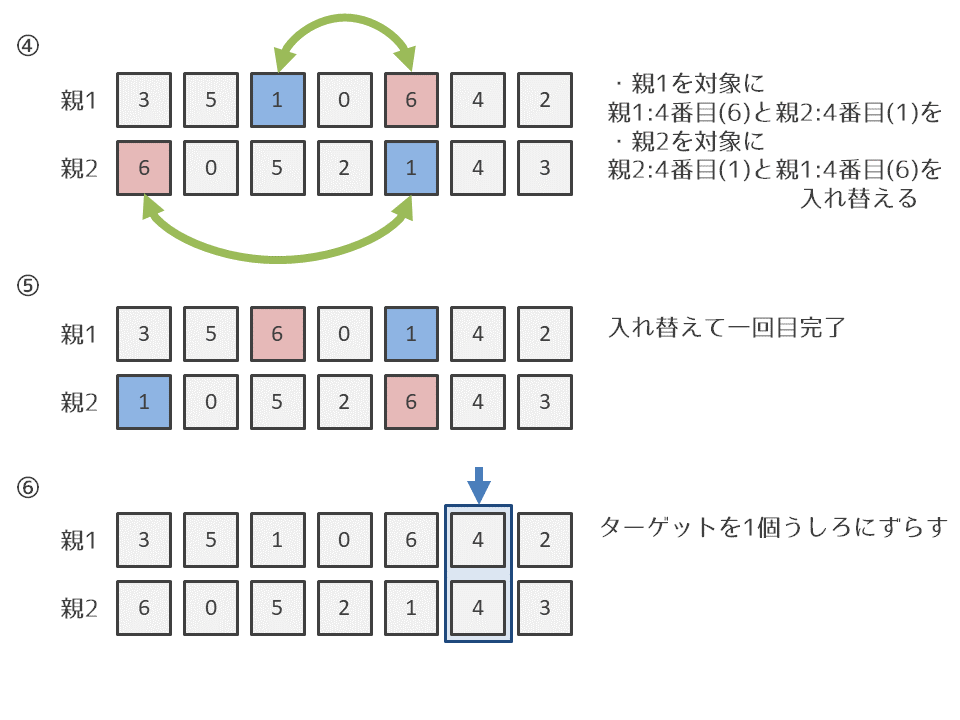
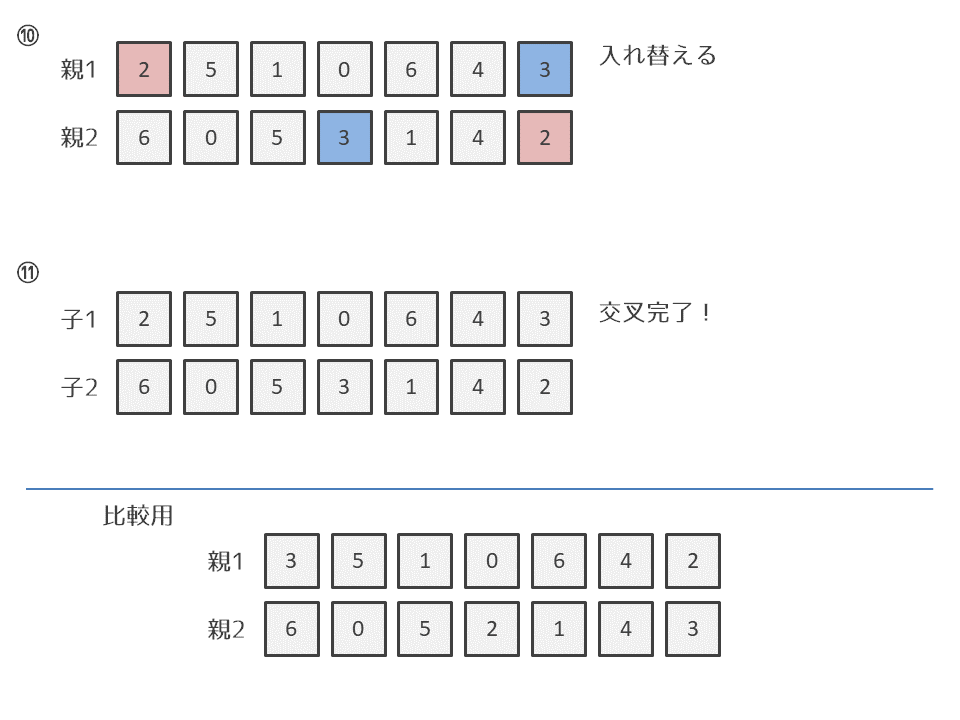

In [103]:
def partial_crossover(parent1, parent2,population):
    num = len(parent1)
    cross_point = random.randrange(1, num-1)
    child1 = parent1
    child2 = parent2
    for i in range(num - cross_point):
        target_index = cross_point + i # prend le target 
        
        target_value1 = parent1[list(parent1.keys())[target_index]]
        target_value2 = parent2[list(parent2.keys())[target_index]]
        
        exchange_index1 = [index for index in range(len(list(parent1.values()))) if list(parent1.values())[index] == target_value2 ]   # trouver les index des deux parents 
        exchange_index2 =  [index for index in range(len(list(parent2.values()))) if list(parent2.values())[index] == target_value1 ] 
 
        child1[list(parent1.keys())[target_index]] = target_value2 # échanger les possitions 
        child2[list(parent2.keys())[target_index]] = target_value1
        
        child1[list(child1.keys())[exchange_index1[0]]] = target_value1
        
        child2[ list(child2.keys())[exchange_index2[0]] ] = target_value2
        
    population.append(child1)
    population.append(child2) 

In [104]:
#child= selection_par_tournois(population)
#partial_crossover(population[child[0]],population[child[1]],population)

### Two Point Crossover

Etant donné deux parcours il faut combiner ces deux parcours pour en construire deux autres.
Nous pouvons suivre la méthode suivante :

1. On choisi aléatoirement deux points de découpe.
2. On interverti, entre les deux parcours, les parties qui se trouvent entre ces deux points.
3. On supprime, à l'extérieur des points de coupe, les villes qui sont déja placées entre les points de coupe.
4. On recense les villes qui n'apparaissent pas dans chacun des deux parcours.
5. On remplit aléatoirement les trous dans chaque parcours. 


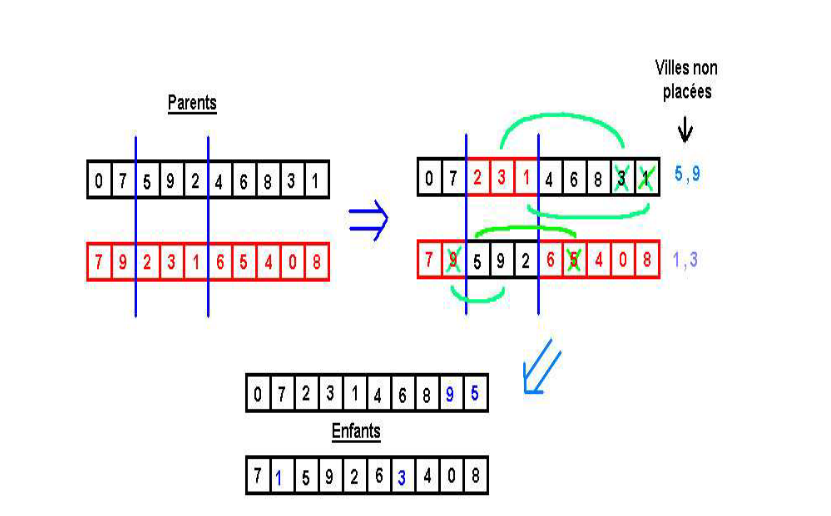

In [105]:
def ajouter_des_sommets(child,parent):
    for k in list(parent.keys()):
            if k not in list(child.keys()):
                child[k]=parent[k]
    return child

def crossover(parent1,parent2,population):
    ##print(" parent1 ",parent1)
    ##print(" parent2 ",parent2)
    num= len(parent1)
    cross= random.sample(range(0, len(parent1)), 2)
    cross_point1=cross[0]
    cross_point2=cross[1]
    child1={}
    child2={}
 
    if cross_point1 < cross_point2:
        for i in range(cross_point1,cross_point2):
            child1[list(parent2.keys())[i]]=parent2[list(parent2.keys())[i]]
            child2[list(parent1.keys())[i]]=parent1[list(parent1.keys())[i]]
            ## ajouter ce qui reste 
            child1=ajouter_des_sommets(child1,parent1)
            child2=ajouter_des_sommets(child2,parent2)
        
                
    
    else:
        for i in range(cross_point2,cross_point1):
            child1[list(parent2.keys())[i]]=parent2[list(parent2.keys())[i]]
            child2[list(parent1.keys())[i]]=parent1[list(parent1.keys())[i]]
            ## ajouter ce qui reste 
            child1=ajouter_des_sommets(child1,parent1)
            child2=ajouter_des_sommets(child2,parent2)
  
    population.append(child1)
    population.append(child2)
    
    
    
    

In [106]:
#crossover(population[child[0]],population[child[1]],population)


### Mutation :

Il s'agit ici de modifier un des éléments d'un point de l'espace de recherche, soit d'une permutation.
Dans notre cas, cela correspond donc à une ville. Quand une ville doit être mutée, on choisit
aléatoirement une autre ville dans ce problème et on intervertit les deux villes.



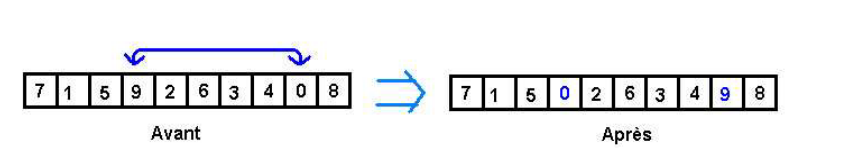

In [107]:
def replace_values(list_to_replace, item_to_replace, item_to_replace_with):
    return [item_to_replace_with if item == item_to_replace else item for item in list_to_replace]

def mutation(population, p_value):
   
    num_mutation=random.randint(0,len(population))
    for i in range(num_mutation):
        individu=population[i]
        mutated_genes = list(individu.keys())
        mutation_flg = np.random.choice(2, 1, p = [1-p_value, p_value])
        if mutation_flg == 1:
            
            mutation_value = random.choices(list(individu), k=2)
            
            #print(mutation_value)
            index = [index for index in range(len(mutated_genes)) if mutated_genes[index] == mutation_value[1]]
            
            mutated_genes=replace_values(mutated_genes,mutation_value[0],mutation_value[1])
            
            #print(index," posi ",mutation_value[1])
            mutated_genes[index[0]]=mutation_value[0]
            
            res={}
            #print(mutated_genes)
            for k in mutated_genes:
                res[k]=individu[k]
                
            ### ajouter le mutated
            population[i]=res
            

In [108]:
"""
   On tue tous individus qu'ont une distance plus grande que la fitness
"""
def death(population,fitness):
    items_to_death=[]
    for i in range(len(population)):
        d=(sum(list(population[i].values())))
        if d  > fitness:
            items_to_death.append(population[i])
            
    for item in items_to_death:        
        population.remove(item)

### Jeu d'essaie 

In [109]:
fitness=0
iteration=1
p_mutation = 0.005
best_individu=[]

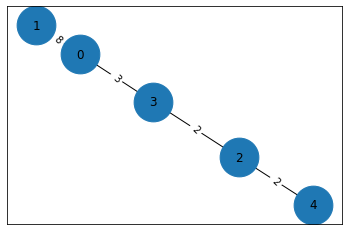

{(0, 1): 8, (0, 3): 3, (2, 3): 2, (2, 4): 2}

In [110]:
i=0
population=create_population(G,edge_labels)
while  i < iteration:
    i+=1
    ## (*) selectionner les meilleurs individus pour le croisement 
    #selection_par_tournois(population) #(i) algo 2 
    distance=table_distance(population) #(ii) algo 1 
    ix_p1,ix_p2= roulette_choice([1/i for i in distance])
    ## (**) Faire le croisement 
    crossover(population[ix_p1],population[ix_p2],population)
    ## (***) Faire la mutation  
    mutation(population, p_mutation)
    distance=table_distance(population)
    ## (****) évaluer les individus  
    distance=[1/i for i in distance]
    if max(distance) > fitness:
        fitness=max(distance)
        
        index = [index for index in range(len(distance)) if distance[index] == fitness][0]
        best_individu=population[index]
        
    death(population,fitness)



G = nx.Graph()  # DiGraph

for n in best_individu:
    G.add_edges_from([n], weight=best_individu[n])

edge_labels=dict([((u,v,),d['weight'])for u,v,d in G.edges(data=True)])
pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw_networkx(G,pos, node_size=1500,edge_cmap=plt.cm.Reds)
pylab.show()


best_individu